Demo #4: Forecasting with cutomized dependencies

Import libraries

In [ ]:
import sys
import os
from pathlib import Path
project_root = Path.cwd().resolve().parents[1]
sys.path.append(str(project_root))
# project_root = Path("/Users/vuongdai/GitHub/canari")  
# sys.path.append(str(project_root))  

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from examples import DataProcess
from pytagi import Normalizer
import pytagi.metric as metric
import copy

Import components

In [2]:
from src import (
    LocalTrend,
    LocalAcceleration,
    LstmNetwork,
    Periodic,
    Autoregression,
    WhiteNoise,
    Model,
    plot_data,
    plot_prediction,
    plot_states,
)

/opt/miniconda3/envs/canari/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-28 13:07:43,056	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-03-28 13:07:43,213	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Read data

In [3]:
data_file = "/Users/vuongdai/GitHub/canari/data/benchmark_data/test_4_data.csv"
df = pd.read_csv(data_file, skiprows=1, delimiter=",", header=None)
time = pd.to_datetime(df.iloc[:, 0])
df = df.iloc[:, 1:]
df.index = time
df.index.name = "time"
df.columns = ["crack opening", "water_level", "temp_min", "temp_max"]
df.head()

crack opening  water_level  temp_min  temp_max
time                                                      
2010-11-07       6.595455    31.053636      -2.2       3.5
2010-11-14       6.523333    30.986667      -1.7       9.9
2010-11-21       6.430000    31.070000      -5.8       1.6
2010-11-28       6.360000    31.000000     -11.5       0.1
2010-12-05       6.210000    30.930000      -5.1      -1.1

Customize dependencies:\
- Lagged values
- Moving averages

In [4]:
lags = [0, 1, 2, 1]
df_lag = DataProcess.add_lagged_columns(df, lags)
df_lag.head()

crack opening  water_level  water_level_lag1  temp_min  \
time                                                                 
2010-11-07       6.595455    31.053636          0.000000      -2.2   
2010-11-14       6.523333    30.986667         31.053636      -1.7   
2010-11-21       6.430000    31.070000         30.986667      -5.8   
2010-11-28       6.360000    31.000000         31.070000     -11.5   
2010-12-05       6.210000    30.930000         31.000000      -5.1   

            temp_min_lag1  temp_min_lag2  temp_max  temp_max_lag1  
time                                                               
2010-11-07            0.0            0.0       3.5            0.0  
2010-11-14           -2.2            0.0       9.9            3.5  
2010-11-21           -1.7           -2.2       1.6            9.9  
2010-11-28           -5.8           -1.7       0.1            1.6  
2010-12-05          -11.5           -5.8      -1.1            0.1

In [5]:
df_lag['MA_temp_max'] =  df_lag['temp_max'].rolling(window=3).mean()

Data preprocess

In [6]:
output_col = [0]
data_processor = DataProcess(
    data=df_lag,
    time_covariates=["week_of_year"],
    train_split=0.4,
    validation_split=0.07,
    output_col=output_col,
)
train_data, validation_data, test_data, normalized_data = data_processor.get_splits()
data_processor.data.head()

crack opening  water_level  water_level_lag1  temp_min  \
time                                                                 
2010-11-07       6.595455    31.053636          0.000000      -2.2   
2010-11-14       6.523333    30.986667         31.053636      -1.7   
2010-11-21       6.430000    31.070000         30.986667      -5.8   
2010-11-28       6.360000    31.000000         31.070000     -11.5   
2010-12-05       6.210000    30.930000         31.000000      -5.1   

            temp_min_lag1  temp_min_lag2  temp_max  temp_max_lag1  \
time                                                                
2010-11-07            0.0            0.0       3.5            0.0   
2010-11-14           -2.2            0.0       9.9            3.5   
2010-11-21           -1.7           -2.2       1.6            9.9   
2010-11-28           -5.8           -1.7       0.1            1.6   
2010-12-05          -11.5           -5.8      -1.1            0.1   

            MA_temp_max  week_of_year  
time                                   
2010-11-07          NaN          44.0  
2010-11-14          NaN          45.0  
2010-11-21     5.000000          46.0  
2010-11-28     3.866667          47.0  
2010-12-05     0.200000          48.0

Define model from components

In [7]:
local_trend = LocalTrend()
pattern = LstmNetwork(
        look_back_len=14,
        num_features=10, # number of data's columns + time covariates
        num_layer=1,
        num_hidden_unit=50,
        device="cpu",
        manual_seed=1,
    )
residual = WhiteNoise(std_error=0.04168)

model = Model(local_trend, pattern, residual)

Train model -- Objective: train LSTM neural network -- model.lstm_train()

In [8]:
model.auto_initialize_baseline_states(train_data["y"][0 : 52 * 3])
max_num_epoch = 50
states_optim = None
mu_validation_preds_optim = None
std_validation_preds_optim = None

for epoch in range(max_num_epoch):
    mu_validation_preds, std_validation_preds, states = model.lstm_train(
        train_data=train_data,
        validation_data=validation_data,
    )

    mu_validation_preds_unnorm = Normalizer.unstandardize(
        mu_validation_preds,
        data_processor.norm_const_mean[data_processor.output_col],
        data_processor.norm_const_std[data_processor.output_col],
    )

    std_validation_preds_unnorm = Normalizer.unstandardize_std(
        std_validation_preds,
        data_processor.norm_const_std[data_processor.output_col],
    )

    validation_obs = data_processor.get_data("validation").flatten()
    validation_log_lik = metric.log_likelihood(
        prediction=mu_validation_preds_unnorm,
        observation=validation_obs,
        std=std_validation_preds_unnorm,
    )

    model.early_stopping(evaluate_metric=-validation_log_lik, mode="min")

    if epoch == model.optimal_epoch:
        mu_validation_preds_optim = mu_validation_preds.copy()
        std_validation_preds_optim = std_validation_preds.copy()
        states_optim = copy.copy(states)
    if model.stop_training:
        break

Learning's curve

Optinal epoch       : 19
Validation MSE      :-0.8659


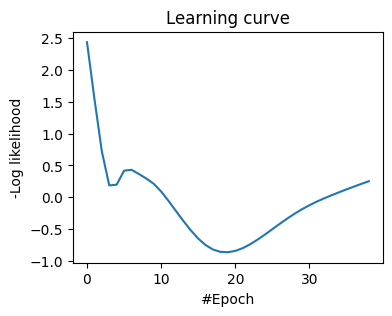

In [9]:
fig,ax = plt.subplots(figsize=(4,3))
plt.plot(model.early_stop_metric_history)
ax.set_ylabel("-Log likelihood")
ax.set_xlabel("#Epoch")
plt.title("Learning curve")
print(f"Optinal epoch       : {model.optimal_epoch}")
print(f"Validation MSE      :{model.early_stop_metric: 0.4f}")

Plot predictions

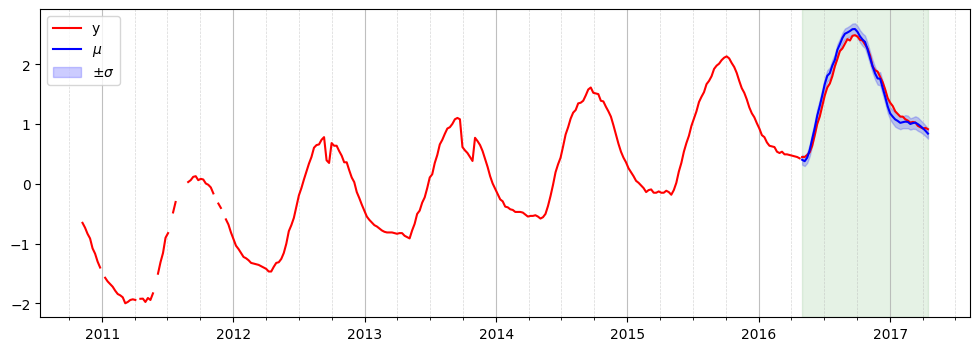

In [10]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_data(
    data_processor=data_processor,
    normalization=True,
    plot_test_data=False,
    plot_column=output_col,
    validation_label="y",
)
plot_prediction(
    data_processor=data_processor,
    mean_validation_pred=mu_validation_preds_optim,
    std_validation_pred=std_validation_preds_optim,
    validation_label=[r"$\mu$", f"$\pm\sigma$"],
)
plt.legend()
plt.show()

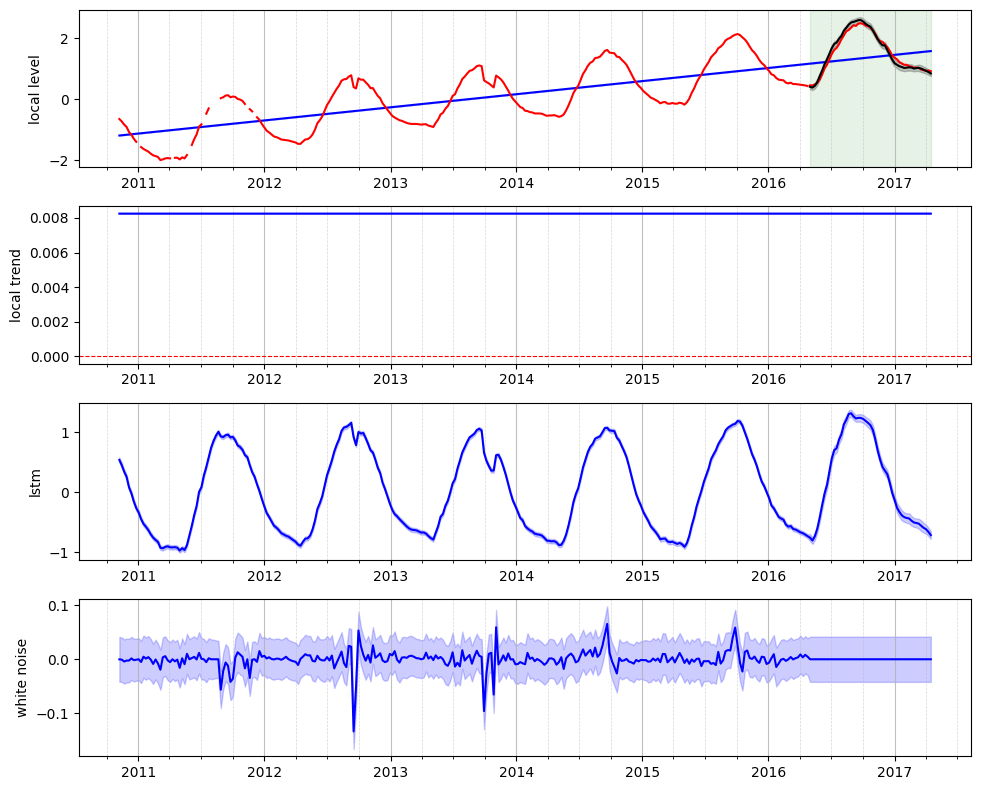

In [11]:
fig, ax =plot_states(data_processor=data_processor, normalization=True,
                     states=states)
plot_data(data_processor=data_processor,
        normalization=True,
        plot_test_data=False,
        sub_plot=ax[0])
plot_prediction(data_processor=data_processor,
                mean_validation_pred=mu_validation_preds_optim,
                std_validation_pred = std_validation_preds_optim,
                sub_plot=ax[0],
                color="k",
                )
plt.show()